# Usando IA para etectar imagenes 💻 🧠

### Pontificia Universidad Católica de Valparaíso

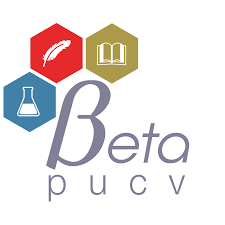


Notas: 

1.   Si deseas seguir experimentando, recarga el archivo en: Entorno de ejecución -> Reiniciar entorno de ejecución

2.   Los resultados no quedan guardados. Para guardar una imagen da click derecho en la misma y 'descargar imagen'.

3.   Algunas actividades de este módulo solicitan acceso a tu cámara web. Asegurate de tener habilitado esto en tu navegador para poder acceder a todos los experimentos!

## Instalación y configuración

In [ ]:
#@title Descarga/instalación YOLOv7

!git clone https://github.com/WongKinYiu/yolov7
%cd yolov7
!pip install -q -r requirements.txt

In [ ]:
#@title Imports

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import os.path
from os import path

import matplotlib.pyplot as plt

In [ ]:
#@title Crear carpeta para guardar pesos

if path.exists('/content/yolov7/weights') == False:
  os.mkdir('/content/yolov7/weights')

WEIGHTS_PATH = '/content/yolov7/weights/'

In [ ]:
#@title Descarga pesos entrenados para esta experiencia
#peso de detector cliqui
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1BvLSdBhE5hSgHnMflbdcYc5sQ8eDM2DS' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1BvLSdBhE5hSgHnMflbdcYc5sQ8eDM2DS" -O best.pt && rm -rf /tmp/cookies.txt 
!mv best.pt /content/yolov7/weights

#peso modelo pre-entrenado
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6.pt -P /content/yolov7/weights

In [ ]:
#@title Funciones de ayuda

# js -> OpenCV
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# OpenCV rectangulo -> byte string para video
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
#@title Obteniendo imgs desde cámara
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Tomar foto';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  #for (x,y,w,h) in faces:
   #   img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

## Probando modelo pre entrenado:

In [ ]:
#@title Sacar foto!

try:
  image = take_photo('foto.jpg')
  print('Guardado como: {}'.format(image))
  
  # Show the image which was just taken.
  display(Image(image))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
#@title Inferencia con modelo preentrenado
img = os.path.join('/content/yolov7','foto.jpg')
project_name = 'testingPretrained'
pretrained_weight = 'yolov7-w6.pt'
used_weight = os.path.join(WEIGHTS_PATH, pretrained_weight)

In [ ]:
#detector
!python detect.py --weights $used_weight --conf 0.25 --img-size 640 --source $img --project $project_name

In [ ]:
#@title Resultado: 
detected_img = os.path.join('/content/yolov7/',project_name, 'exp/foto.jpg')
display(Image(detected_img))

## Probando modelo entrenado para Cliqui

In [ ]:
#@title Sacar foto!

try:
  image = take_photo('foto_cliqui.jpg')
  print('Guardado como: {}'.format(image))
  
  # Show the image which was just taken.
  display(Image(image))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
#@title Inferencia con modelo preentrenado para Cliqui
name = 'yolov7-cliqui'
best_weight = 'best.pt'
cliqui_weight = os.path.join(WEIGHTS_PATH, best_weight)
img_cliqui = os.path.join('/content/yolov7','foto_cliqui.jpg')

In [ ]:
#detecor
!python detect.py --weights $cliqui_weight -conf-thres 0.2 --img-size 640 --source $img_cliqui --project $name

In [ ]:
#@title Resultado detección:
img_detected = '/content/yolov7/' + name + "/exp/foto_cliqui.jpg"
display(Image(img_detected))